In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import RZGate

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [5]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 2
numQubit = 1
global iterations
global noisy

In [6]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

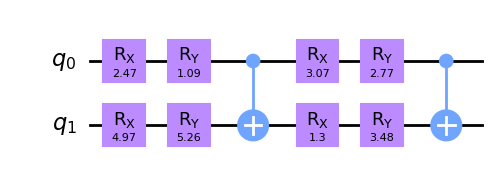

In [7]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 2
layers = 2

for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [8]:
def createEqSuperposCollectiveZ():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(2)
    temp.ry(2*np.arctan(np.sqrt(2)), 1)
    temp.ch(1, 0)
    return temp

In [10]:
'''
Define U_0 gate from Appendix G
'''
U0 = QuantumCircuit(2)
U0.append(RZGate(-2*np.pi/3), [0])
U0.append(RZGate(-2*np.pi/3), [1])

In [26]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Appendix G from https://arxiv.org/pdf/2105.12758
    The ciruit contains 4 qubits each labelled as (C, S, S')
    '''
    circ = QuantumCircuit(4)
    
    superPosCircuit = createEqSuperposCollectiveZ()
    circ.append(superPosCircuit, [0, 1])

    circ.append(state, [2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3])
    
    controlledU0 = U0.to_gate().control(1)
    
    circ.append(controlledU0, [1, 2, 3])
    circ.append(controlledU0, [0, 2, 3])
    
    circ.append(superPosCircuit.inverse(), [0, 1])
    
    return circ

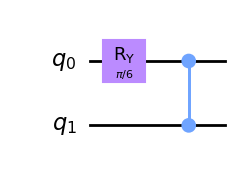

In [84]:
state = QuantumCircuit(2)
state.ry(np.pi/6, 0)
state.cz(0, 1)
state.draw('mpl')

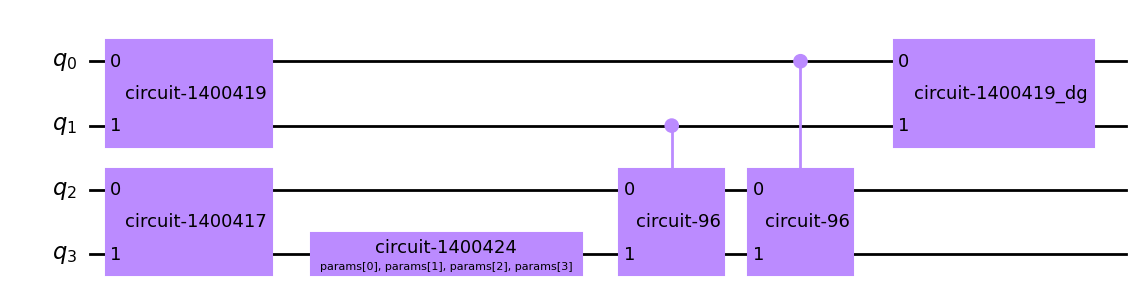

In [85]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(state, numQubit, numLayer)
qCirc.draw('mpl')

In [86]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3])])


In [87]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [88]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

<ipython-input-88-83504aeca076>:8: DeprecationWarning: Passing BackendProperties instead of a "backend" object has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date. Duration dependent delay relaxation noise requires a backend object.
  noise_model = NoiseModel.from_backend(device.properties())


In [89]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [90]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [91]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [92]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first two qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [93]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[6.15505436 2.91564171 5.95936832 4.59562866]
Initial Cost :  0.35616554656227944


In [94]:
'''
True value calculated using the SDP.
'''
true_value = 0.9330

In [95]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.35616554656227944


<ipython-input-95-138481431eb0>:9: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)


Loss Value :  0.9152416531244866 1.0%
Loss Value :  0.9158712276240117 2.0%
Loss Value :  0.9178626698324147 3.0%
Loss Value :  0.9185392257377413 4.0%
Loss Value :  0.932973542771385 5.0%
Loss Value :  0.9329286283685804 6.0%
Loss Value :  0.9328724760694956 7.0%
Loss Value :  0.9328658661948778 8.0%
Loss Value :  0.9329578468062592 9.0%
Loss Value :  0.9329526452784255 10.0%
Loss Value :  0.9330113020380388 11.0%
Loss Value :  0.9330033109260232 12.0%
Loss Value :  0.9330052532040274 13.0%
Loss Value :  0.933008088054431 14.0%
Loss Value :  0.9329968466970362 15.0%
Loss Value :  0.933004031124936 16.0%
Loss Value :  0.9330065520500863 17.0%
Loss Value :  0.9329950668311409 18.0%
Loss Value :  0.9330072510760808 19.0%
Loss Value :  0.9330018542259298 20.0%
Loss Value :  0.9330126606411191 21.0%
Loss Value :  0.9330125010473631 22.0%
Loss Value :  0.9330046131372378 23.0%
Loss Value :  0.9329965895388126 24.0%
Loss Value :  0.9329967638285352 25.0%
Loss Value :  0.9329861810260309 26.0

In [96]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.34912109375000006


<ipython-input-96-8a2498bb173e>:10: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)


Loss Value :  0.2613525390625 1.0%
Loss Value :  0.7221679687499999 2.0%
Loss Value :  0.8570556640625 3.0%
Loss Value :  0.8338623046875 4.0%
Loss Value :  0.8195800781249999 5.0%
Loss Value :  0.8902587890625 6.0%
Loss Value :  0.8640136718750001 7.0%
Loss Value :  0.84033203125 8.0%
Loss Value :  0.8433837890625 9.0%
Loss Value :  0.9169921875000001 10.0%
Loss Value :  0.9217529296875 11.0%
Loss Value :  0.873046875 12.0%
Loss Value :  0.9318847656250001 13.0%
Loss Value :  0.8762207031249999 14.0%
Loss Value :  0.9119873046875 15.0%
Loss Value :  0.9239501953124999 16.0%
Loss Value :  0.9055175781249999 17.0%
Loss Value :  0.9118652343750001 18.0%
Loss Value :  0.8414306640625 19.0%
Loss Value :  0.8779296875 20.0%
Loss Value :  0.8588867187499999 21.0%
Loss Value :  0.8416748046875 22.0%
Loss Value :  0.8499755859375001 23.0%
Loss Value :  0.8974609374999999 24.0%
Loss Value :  0.9116210937500001 25.0%
Loss Value :  0.8819580078124999 26.0%
Loss Value :  0.9166259765625 27.0%
Loss

In [97]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9328133103273708


In [98]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.933
Noiseless :  0.9330118551147372
Noisy :  0.9207763671875001
Noise Resilient Value :  0.9328133103273708


In [65]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("CZ_GBSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [66]:
writeToFile()